# 파생변수 생성

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy.spatial import distance
from math import log2
from math import sqrt
from sklearn.cluster import AgglomerativeClustering

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


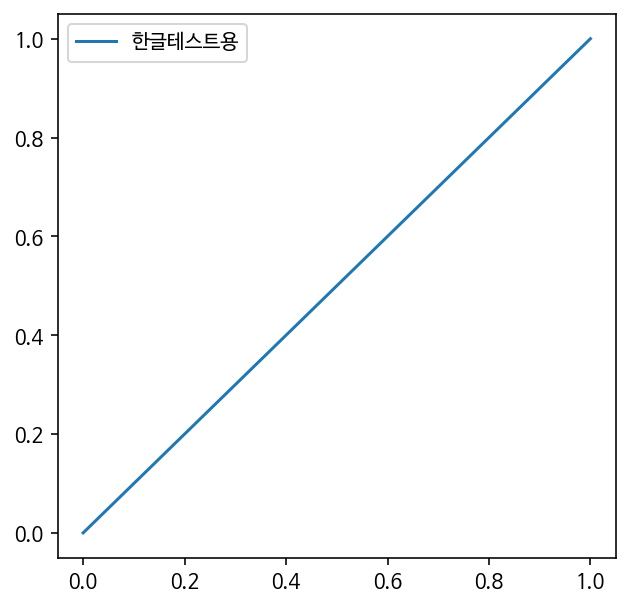

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/빅청캠/real_final.csv')
df.head()

,도시,공사,modified공종명,설계수량,설계재료비단가,설계노무비단가,설계경비단가,설계합계금액,도급수량,도급재료비단가,도급노무비단가,도급경비단가,도급합계금액,공구별면적,주거면적,주거면적(%),공구별세대수,착공연도,준공연도,기간(월),x,y,hdb_clusters
0,광교1,구조물공사,강관파일기초,7337.0,1312053.0,611151.0,25142.0,4.488065e+09,7337.0,920662.0,459434.0,19325.0,3.257416e+09,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,-24.076591,21.306380,254
1,광교1,구조물공사,되메우기및다짐,8973.0,415.0,1675.0,236.0,2.087120e+07,8973.0,212.0,816.0,367.0,1.251734e+07,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,39.149840,-23.925344,292
2,광교1,구조물공사,뒷채움부설및다짐,1558.0,419.0,4200.0,393.0,7.808696e+06,1558.0,214.0,2049.0,615.0,4.483924e+06,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,-6.275611,-40.735214,1019
3,광교1,구조물공사,보강토옹벽,402.0,295266.0,140498.0,10444.0,9.059399e+07,402.0,151507.0,68524.0,16391.0,4.757870e+07,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,34.260254,23.648280,260
4,광교1,구조물공사,식생옹벽블럭,341.0,171792.0,29126.0,14282.0,7.338320e+07,341.0,88150.0,14205.0,22416.0,4.254691e+07,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,27.405354,22.553220,265


In [ ]:
df.loc[df['공사']=='상수도공사','공사'] = '상수공사'

In [ ]:
df['설계단가합계'] = df['설계재료비단가']+df['설계노무비단가']+df['설계경비단가']
df['도급단가합계'] = df['도급재료비단가']+df['도급노무비단가']+df['도급경비단가']

## EDA에서 비롯한 변수 생성

### 공사별 티어 설정

### 공종명 아웃라이어 설정
- RMSE나 R2 값 자체는 이상치에 영향을 많이 받기 때문에, 이상치를 설명해주는 변수를 만드는 것이 좋을 것으로 판단됨.

In [ ]:
df['이상치']=0

In [ ]:
def make_detection(df,num,name_gong):
  togong=df[df['공사']==name_gong].copy()
  togong['설계합계비중']=togong['설계합계금액']/togong['설계합계금액'].sum()
  togong['도급합계비중']=togong['도급합계금액']/togong['도급합계금액'].sum()
  togong['비중차이'] = togong['설계합계비중'] - togong['도급합계비중']
  return togong[abs(togong['비중차이'])>num][['modified공종명','설계합계비중','도급합계비중','비중차이']]

In [ ]:
# 도시별 이상치 concat

for name in df['공사'].unique():
  outlierC=pd.concat([
                      make_detection(df[df['도시']=='동탄2'],0.001,name),
                      make_detection(df[df['도시']=='동탄3'],0.001,name),
                      make_detection(df[df['도시']=='동탄5'],0.001,name),
                      make_detection(df[df['도시']=='다산1'],0.001,name),
                      make_detection(df[df['도시']=='다산2'],0.001,name),
                      make_detection(df[df['도시']=='광교1'],0.001,name)])
  for idx in outlierC.index:
    df.loc[(df['modified공종명']==df.loc[idx,'modified공종명'])&
           (df['공사']==name),
           '이상치']=1

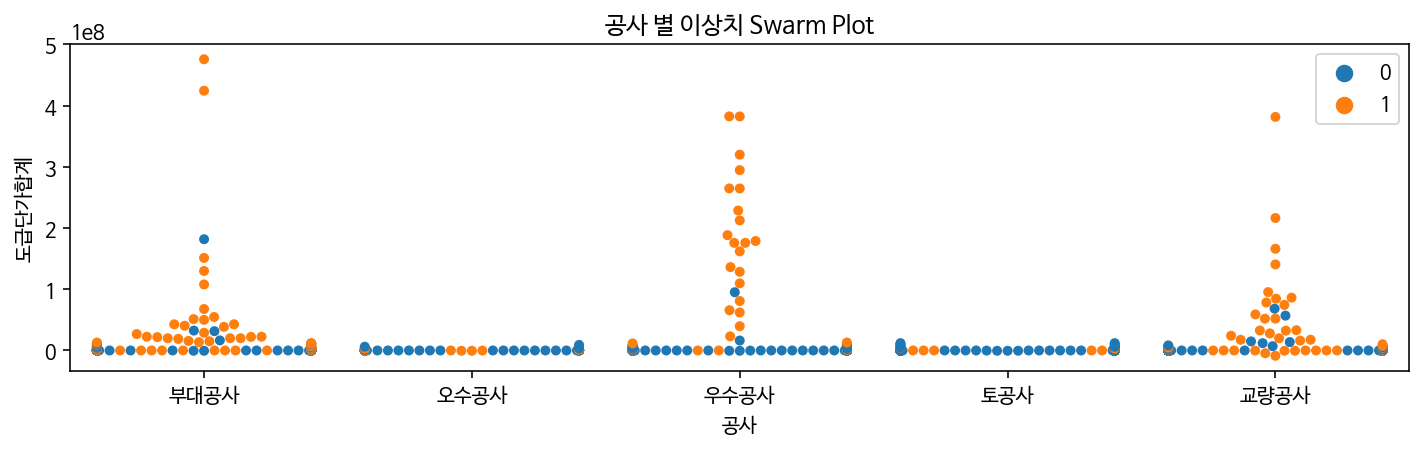

In [ ]:
plt.figure(figsize=(12, 3))
sns.swarmplot(x='공사',y="도급단가합계", hue="이상치", data=df[(df['공사']=='교량공사')|(df['공사']=='우수공사')|(df['공사']=='토공사')|(df['공사']=='공사')|(df['공사']=='부대공사')|(df['공사']=='오수공사')])
plt.title("공사 별 이상치 Swarm Plot")
plt.legend(loc=1)
plt.show()

In [ ]:
df['공사'].unique()

array(['구조물공사', '기타도로공사', '도로및포장공사', '부대공사', '상수공사', '오수공사', '우수공사',
       '토공사', '가로수식재공사', '교량공사', '하천공사', '가로수유지관리공사'], dtype=object)

### 구릉지
- 전체 면적의 12%

### HDbscan 평균,편차 변수 생성

In [ ]:
hdb_mean = df.groupby(['hdb_clusters'])['도급단가합계'].mean().reset_index(name='hdb_mean')
hdb_std = df.groupby(['hdb_clusters'])['도급단가합계'].std().reset_index(name='hdb_std')

In [ ]:
df = df.merge(hdb_mean,on='hdb_clusters',how='left')
df = df.merge(hdb_std,on='hdb_clusters',how='left')

## 클러스터링을 통한 변수 생성

클러스터를 만들 변수들을 생성하자.

In [ ]:
# 단가합계
df['설계단가합계'] = df['설계재료비단가']+df['설계노무비단가']+df['설계경비단가']
df['도급단가합계'] = df['도급재료비단가']+df['도급노무비단가']+df['도급경비단가']

# 단가합계비중
df['도단합/전단합'] = df['도급단가합계']/(df['설계단가합계']+df['도급단가합계'])

# 수량비중
df['도수량/전수량'] = df['도급수량']/(df['설계수량']+df['도급수량'])

In [ ]:
def JensenShannon_similarity(df,input_list,cal_list,st_name):
  '''
  [함수 사용법]
  input_list에는 groupby에 들어갈 기준 컬럼들 선택,
  st_name은 도급단가합계 또는 비중차이로 접근할 것
  '''
  
  make_price = df.groupby(input_list)[st_name].sum().reset_index()
  name_list= make_price['modified공종명']
  # pivot 만들기
  price_sum = df.groupby(cal_list)[st_name].sum().reset_index(name='단가합계')
  make_price = make_price.merge(price_sum,on=cal_list,how='left')
  
  if st_name == '도급단가합계':
    make_price['price_prob'] = make_price[st_name]/make_price['단가합계']
  else:
    '''
    도수량/전수량 변수는 비중의 변화를 비교하는 것이기 때문에
    합계로 다시 나눌 필요가 없음.
    '''              
    make_price['price_prob'] = make_price[st_name]
  
  #pivot_table을 활용하여 long to wide 작업 실시
  price_pivot= pd.pivot_table(make_price,
                            index= 'modified공종명', # 분포 기준
                            columns=cal_list,       # 분포 x축
                            values='price_prob').reset_index()
  price_pivot.fillna(0,inplace=True)
  price_pivot.columns.get_level_values(level=0)
  name_list = price_pivot['modified공종명']
  '''
  cal_list가 2개 이상이면 pivot_table의 column이
  Multiindex형태로 바껴버리기 때문에 미리 이름을 꺼내 놓는 것.
  '''
  
  #피벗된 price를 사용해 고객간의 유사도를 구해보자.
  price_array=np.array(price_pivot.drop('modified공종명',axis=1))

  js_similarity =[]
  for row_r in range(price_array.shape[0]):       
    dt_list=[]
    for row_c in range(price_array.shape[0]):
        #dt= js_divergence(price_pivot.iloc[row_r,3:].values,price_pivot.iloc[row_c,3:].values)
        '''
        js_divergence(만든 함수)로 하면 0값을 계산을 못함. 
        sqrt(js_divergence)인 distance.jensenshannon 함수 사용
        '''
        dt = distance.jensenshannon(price_array[row_r,:],price_array[row_c,:],2.0)
        dt_list.append(dt)
    js_similarity.append(dt_list)

  js_frame =pd.DataFrame(np.array(js_similarity))
  js_similarity = pd.concat([price_pivot,js_frame],axis=1)

  return name_list,js_similarity

In [ ]:
def make_clustering(gp_df,input_list,cal_list,st_name,col_name,split_num=2):
    name_list,df = JensenShannon_similarity(gp_df,input_list,cal_list,st_name)
    df_s = df.iloc[:,-df.shape[0]:] # 클러스터링용 dataframe 생성
    df_s.fillna(0,inplace=True)

    #클러스터링
    clustering = AgglomerativeClustering(n_clusters=int(df_s.shape[0]/2),
                                      affinity='precomputed',
                                      linkage='average')
    clustering.fit(df_s)

    #df_s.columns = name_list
    #df_s.index = name_list
    #df_s.to_csv('/content/drive/My Drive/Colab Notebooks/data/빅청캠/distance_d.csv',encoding='utf-8-sig')

    return pd.DataFrame({'modified공종명':name_list,
                         col_name:clustering.labels_})

In [ ]:
df = df.merge(make_clustering(df,['도시','modified공종명'],['도시'],'도급단가합계','도-단cluster',2),on='modified공종명',how='left')

In [ ]:
df = df.merge(make_clustering(df,['도시','modified공종명'],['도시'],'도급단가합계','도-단cluster',2),on='modified공종명',how='left')
df = df.merge(make_clustering(df,['공사','modified공종명'],['공사'],'도급단가합계','공-단cluster',2),on='modified공종명',how='left')
df = df.merge(make_clustering(df,['도시','공사','modified공종명'],['도시','공사'],'도급단가합계','도공-단cluster',2),on='modified공종명',how='left')  

df = df.merge(make_clustering(df,['도시','modified공종명'],['도시'],'도단합/전단합','도-단비cluster',2),on='modified공종명',how='left')
df = df.merge(make_clustering(df,['공사','modified공종명'],['공사'],'도단합/전단합','공-단비cluster',2),on='modified공종명',how='left')
df = df.merge(make_clustering(df,['도시','공사','modified공종명'],['도시','공사'],'도단합/전단합','도공-단비cluster',2),on='modified공종명',how='left')

df = df.merge(make_clustering(df,['도시','modified공종명'],['도시'],'도수량/전수량','도-수비cluster',2),on='modified공종명',how='left')
df = df.merge(make_clustering(df,['공사','modified공종명'],['공사'],'도수량/전수량','공-수비cluster',2),on='modified공종명',how='left')
df = df.merge(make_clustering(df,['도시','공사','modified공종명'],['도시','공사'],'도수량/전수량','도공-수비cluster',2),on='modified공종명',how='left')

KeyboardInterrupt: ignored

In [ ]:
def make_pasang(input_df,name):
  group_mean = input_df.groupby([name])['도급단가합계'].mean().reset_index(name=name+'mean')
  group_std = input_df.groupby([name])['도급단가합계'].std().reset_index(name=name+'std')
  input_df = input_df.merge(group_mean,on=name,how='left')
  input_df = input_df.merge(group_std,on=name,how='left')

  return input_df

In [ ]:
for col in ['도-단cluster', '공-단cluster', '도공-단cluster', '도-단비cluster', '공-단비cluster','도공-단비cluster', '도-수비cluster', '공-수비cluster', '도공-수비cluster']:
  df = make_pasang(df,col)
df.head()

,도시,공사,modified공종명,설계수량,설계재료비단가,설계노무비단가,설계경비단가,설계합계금액,도급수량,도급재료비단가,도급노무비단가,도급경비단가,도급합계금액,공구별면적,주거면적,주거면적(%),공구별세대수,착공연도,준공연도,기간(월),x,y,hdb_clusters,설계단가합계,도급단가합계,이상치,hdb_mean,hdb_std,도단합/전단합,도수량/전수량,도-단cluster,공-단cluster,도공-단cluster,도-단비cluster,공-단비cluster,도공-단비cluster,도-수비cluster,공-수비cluster,도공-수비cluster,도-단clustermean,도-단clusterstd,공-단clustermean,공-단clusterstd,도공-단clustermean,도공-단clusterstd,도-단비clustermean,도-단비clusterstd,공-단비clustermean,공-단비clusterstd,도공-단비clustermean,도공-단비clusterstd,도-수비clustermean,도-수비clusterstd,공-수비clustermean,공-수비clusterstd,도공-수비clustermean,도공-수비clusterstd
0,광교1,구조물공사,강관파일기초,7337.0,1312053.0,611151.0,25142.0,4.488065e+09,7337.0,920662.0,459434.0,19325.0,3.257416e+09,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,-24.076591,21.306380,254,1948346.0,1399421.0,1,383301.857143,485940.558325,0.418016,0.5,17,6,9,2,22,74,22,3,80,1.936300e+06,1.235332e+07,318080.400000,608002.829725,586871.333333,705899.572921,905478.762774,2.400655e+06,318080.400000,608002.829725,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413
1,광교1,구조물공사,되메우기및다짐,8973.0,415.0,1675.0,236.0,2.087120e+07,8973.0,212.0,816.0,367.0,1.251734e+07,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,39.149840,-23.925344,292,2326.0,1395.0,0,9276.842105,10462.150381,0.374899,0.5,407,372,500,444,543,631,479,607,303,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8410.142857,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039
2,광교1,구조물공사,뒷채움부설및다짐,1558.0,419.0,4200.0,393.0,7.808696e+06,1558.0,214.0,2049.0,615.0,4.483924e+06,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,-6.275611,-40.735214,1019,5012.0,2878.0,1,10549.523810,14778.036032,0.364766,0.5,520,415,253,625,416,423,595,439,503,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4952.800000,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452
3,광교1,구조물공사,보강토옹벽,402.0,295266.0,140498.0,10444.0,9.059399e+07,402.0,151507.0,68524.0,16391.0,4.757870e+07,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,34.260254,23.648280,260,446208.0,236422.0,1,163376.000000,103302.643877,0.346340,0.5,17,678,9,2,369,74,22,3,80,1.936300e+06,1.235332e+07,236422.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,236422.000000,NaN,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413
4,광교1,구조물공사,식생옹벽블럭,341.0,171792.0,29126.0,14282.0,7.338320e+07,341.0,88150.0,14205.0,22416.0,4.254691e+07,1067184.0,604873.6,56.67941,9177.0,200710,201105,43.0,27.405354,22.553220,265,215200.0,124771.0,1,30559.428571,47851.742577,0.367005,0.5,17,672,9,2,311,338,504,3,204,1.936300e+06,1.235332e+07,124771.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,124771.000000,NaN,124771.000000,NaN,1.247710e+05,NaN,124222.157895,318363.549917,124771.000000,NaN


In [ ]:
df_boosting=df[['도시', '공사', 'modified공종명', '설계수량', '공구별면적','주거면적', '주거면적(%)', '공구별세대수','기간(월)','이상치',
                'hdb_clusters','hdb_mean', 'hdb_std',
                '도-단cluster', '공-단cluster', '도공-단cluster', '도-단비cluster', '공-단비cluster','도공-단비cluster', '도-수비cluster', '공-수비cluster', '도공-수비cluster',
                '도-단clustermean', '도-단clusterstd','공-단clustermean', '공-단clusterstd', '도공-단clustermean', '도공-단clusterstd','도-단비clustermean', '도-단비clusterstd', '공-단비clustermean','공-단비clusterstd', '도공-단비clustermean', '도공-단비clusterstd','도-수비clustermean', '도-수비clusterstd', '공-수비clustermean','공-수비clusterstd', '도공-수비clustermean', '도공-수비clusterstd',
                '도급단가합계']]

df_svr=df[['도시', '공사', 'modified공종명', '설계수량', '공구별면적','주거면적', '주거면적(%)', '공구별세대수','기간(월)','이상치',
           'hdb_mean', 'hdb_std',
           '도-단clustermean', '도-단clusterstd','공-단clustermean', '공-단clusterstd', '도공-단clustermean', '도공-단clusterstd','도-단비clustermean', '도-단비clusterstd', '공-단비clustermean','공-단비clusterstd', '도공-단비clustermean', '도공-단비clusterstd','도-수비clustermean', '도-수비clusterstd', '공-수비clustermean','공-수비clusterstd', '도공-수비clustermean', '도공-수비clusterstd',
           '도급단가합계']]

In [ ]:
df_boosting.to_csv('/content/drive/My Drive/Colab Notebooks/data/빅청캠/df_boosting.csv',encoding='utf-8-sig',index=False)
df_svr.to_csv('/content/drive/My Drive/Colab Notebooks/data/빅청캠/df_svr.csv',encoding='utf-8-sig',index=False)